# Symptom‑Extraction Evaluation Notebook  
This notebook reproduces the metrics reported in Section 5.3 (May 2025 update).

* **Dataset**: `symptom_extraction_results.csv` (914 patient utterances)  
* **Goal**: compute mention‑level TP/FP/FN counts, micro/macro/sample‑averaged Precision/Recall/F1, micro Jaccard similarity, and a confusion heat‑map for the 20 most frequent symptom labels.

Feel free to tweak the parameters (e.g. `TOP_K` or the normalisation function) to explore different slices of the data.


In [ ]:
import pandas as pd
import numpy as np
import ast
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, jaccard_score
import matplotlib.pyplot as plt


## 1. Load data

In [ ]:
CSV_PATH = '/content/symptom_extraction_results.csv'
df = pd.read_csv(CSV_PATH)
print(f"Dataset loaded: {df.shape[0]} utterances")
df.head()

Dataset loaded: 914 utterances


,utterance,llm_predicted,actual_output
0,"Sure, I'm I'm just having a lot of chest pain ...",['chest pain'],['chest pain']
1,"Sure 39, I'm a male.","['Fatigue', 'Headache']",[]
2,"It started last night, but it's becoming sharper.","['Sharp pain in the chest', 'Rapid heartbeat']",['becoming sharper']
3,It's located on the left side of my chest.,['Left-sided chest pain'],['pain on the left side of my chest']
4,"So I guess it would be a couple of hours now, ...",[],[]


## 2. Prediction and gold lists

In [ ]:
def normalise(lst):
    # simple normalisation – lower‑case & trim whitespace
    return [s.lower().strip() for s in lst]

df['pred_list'] = df['llm_predicted'].apply(ast.literal_eval).apply(normalise)
df['gold_list'] = df['actual_output'].apply(ast.literal_eval).apply(normalise)
print("Parsed columns created: pred_list, gold_list")

Parsed columns created: pred_list, gold_list


## 3. Dataset summary

In [ ]:
num_docs = len(df)
docs_with_gold = (df['gold_list'].str.len() > 0).sum()
print(f"Total documents: {num_docs}")
print(f"Documents with ≥1 gold mention: {docs_with_gold} ({docs_with_gold/num_docs:.1%})")
print(f"Average # predicted mentions: {df['pred_list'].str.len().mean():.3f}")
print(f"Average # gold mentions:      {df['gold_list'].str.len().mean():.3f}")

Total documents: 914
Documents with ≥1 gold mention: 157 (17.2%)
Average # predicted mentions: 0.287
Average # gold mentions:      0.258


## 4. Compute mention‑level TP / FP / FN

In [ ]:
TP = FP = FN = 0
for gold, pred in zip(df['gold_list'], df['pred_list']):
    gold_set, pred_set = set(gold), set(pred)
    TP += len(gold_set & pred_set)
    FP += len(pred_set - gold_set)
    FN += len(gold_set - pred_set)

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

precision = TP / (TP + FP) if TP + FP else 0
recall    = TP / (TP + FN) if TP + FN else 0
f1        = 2 * precision * recall / (precision + recall) if precision + recall else 0
print(f"Micro Precision: {precision:.3f}")
print(f"Micro Recall:    {recall:.3f}")
print(f"Micro F1:        {f1:.3f}")

True Positives (TP): 185
False Positives (FP): 77
False Negatives (FN): 51
Micro Precision: 0.706
Micro Recall:    0.784
Micro F1:        0.743


## 5. sklearn micro / macro / samples metrics

In [ ]:
mlb = MultiLabelBinarizer()
Y_gold = mlb.fit_transform(df['gold_list'])
Y_pred = mlb.transform(df['pred_list'])
print(classification_report(Y_gold, Y_pred, target_names=mlb.classes_))

print("Micro Jaccard similarity:",
      jaccard_score(Y_gold, Y_pred, average='micro'))

                                                                               precision    recall  f1-score   support

                                                                                    0.00      0.00      0.00         1
a1c levels have been high, especially recently with an 8.8 or higher reading.       1.00      1.00      1.00         1
                                                             abdominal cramps       1.00      1.00      1.00         1
                                                               abdominal pain       1.00      1.00      1.00         2
                                       abdominal pain located below the lungs       1.00      1.00      1.00         1
                                                                         ache       1.00      1.00      1.00         2
                                                                    achy pain       0.00      0.00      0.00         1
                                               

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['car parts', 'carrying heavy objects', 'chest pressure', 'experiencing fatigue', 'hurt', 'i am going to the washroom', "i'm feeling a bit off", 'joint warmth', 'left-sided chest pain', 'lightheadedness', 'metformin', 'muscle strain', 'neck swelling', 'no blood in urine', 'no strokes', 'noise from neighbors', "partner's constant phone usage", 'rapid heartbeat', 'rashes', 'respiratory issues', 'rosuvastatin', 'sleep deprivation due to late-night childcare duties', 'sore throat', 'stress levels high due to family responsibilities', 'taking 4 pills right now', 'unexplained fatigue', 'weird noises at night'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

## 6. Confusion heat‑map (top‑k frequent labels)

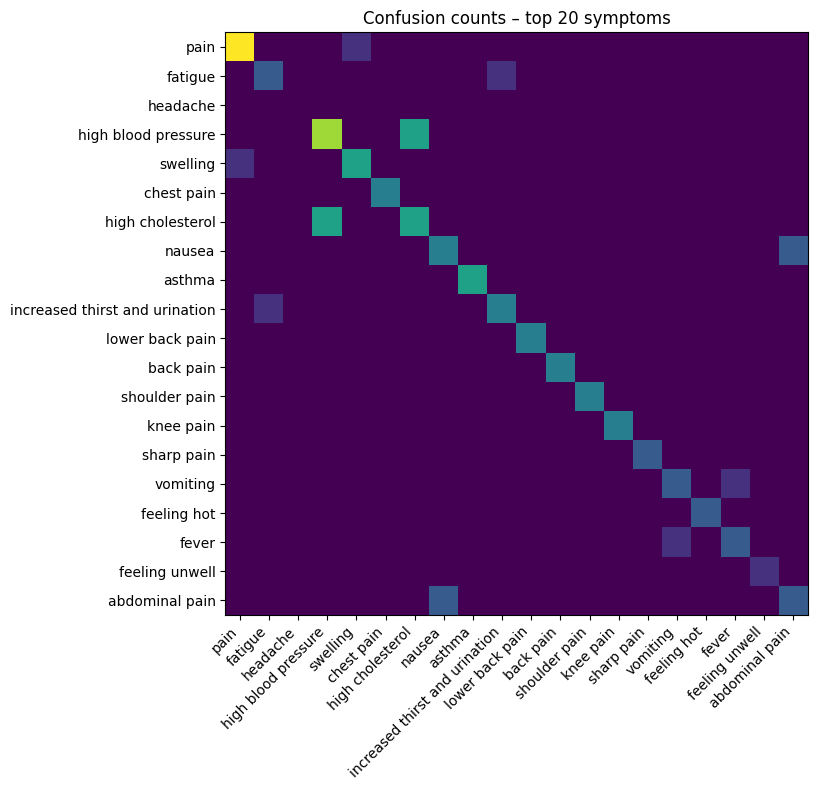

In [ ]:
# Build full label set & counts
all_labels = [s for sub in df['gold_list'] for s in sub] +              [s for sub in df['pred_list'] for s in sub]
freq_counter = Counter(all_labels)
TOP_K = 20
top_labels = [l for l,_ in freq_counter.most_common(TOP_K)]

label_to_idx = {l:i for i,l in enumerate(top_labels)}
cm = np.zeros((TOP_K, TOP_K), dtype=int)

for gold, pred in zip(df['gold_list'], df['pred_list']):
    for g in gold:
        for p in pred:
            if g in label_to_idx and p in label_to_idx:
                cm[label_to_idx[g], label_to_idx[p]] += 1

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm)
ax.set_xticks(np.arange(TOP_K))
ax.set_yticks(np.arange(TOP_K))
ax.set_xticklabels(top_labels, rotation=45, ha='right')
ax.set_yticklabels(top_labels)
ax.set_title(f"Confusion counts – top {TOP_K} symptoms")
plt.tight_layout()
plt.show()

## 7. Future work
* Evaluate token‑overlap (Dice / IoU) for partial‑credit analysis.  
* Add error‑bucket sampling to inspect typical FP and FN cases.  
* Compare multiple model checkpoints by appending their results to a summary DataFrame.